# Structure Sanitization

http://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization

The molecule parsing functions all, by default, perform a “sanitization” operation on the molecules read. The idea is to generate useful computed properties (like hybridization, ring membership, etc.) for the rest of the code and to ensure that the molecules are “reasonable”: that they can be represented with octet-complete Lewis dot structures.

Here are the steps involved, in order.

Here are the steps involved, in order.

        clearComputedProps: removes any computed properties that already exist

            on the molecule and its atoms and bonds. This step is always performed.

        cleanUp: standardizes a small number of non-standard valence states. The clean up operations are:

                Neutral 5 valent Ns with double bonds to Os are converted to the zwitterionic form. Example: N(=O)=O -> [N+](=O)O-]

                Neutral 5 valent Ns with triple bonds to another N are converted to the zwitterionic form. Example: C-N=N#N -> C-N=[N+]=[N-]

                Neutral 5 valent phosphorus with one double bond to an O and another to either a C or a P are converted to the zwitterionic form. Example: C=P(=O)O -> C=[P+]([O-])O

                Neutral Cl, Br, or I with exclusively O neighbors, and a valence of 3, 5, or 7, are converted to the zwitterionic form. This covers things like chlorous acid, chloric acid, and perchloric acid. Example: O=Cl(=O)O -> [O-][Cl+2][O-]O

        This step should not generate exceptions.

        updatePropertyCache: calculates the explicit and implicit valences on all atoms. This generates exceptions for atoms in higher-than-allowed valence states. This step is always performed, but if it is “skipped” the test for non-standard valences will not be carried out.

        symmetrizeSSSR: calls the symmetrized smallest set of smallest rings algorithm (discussed in the Getting Started document).

        Kekulize: converts aromatic rings to their Kekule form. Will raise an exception if a ring cannot be kekulized or if aromatic bonds are found outside of rings.

        assignRadicals: determines the number of radical electrons (if any) on each atom.

        setAromaticity: identifies the aromatic rings and ring systems (see above), sets the aromatic flag on atoms and bonds, sets bond orders to aromatic.

        setConjugation: identifies which bonds are conjugated

        setHybridization: calculates the hybridization state of each atom

        cleanupChirality: removes chiral tags from atoms that are not sp3 hybridized.

        adjustHs: adds explicit Hs where necessary to preserve the chemistry. This is typically needed for heteroatoms in aromatic rings. The classic example is the nitrogen atom in pyrrole.

The individual steps can be toggled on or off when calling MolOps::sanitizeMol or Chem.SanitizeMol.


In [16]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.ipython_useSVG=True

In [3]:
m = Chem.MolFromSmiles('Cn(:n):o')

RDKit ERROR: [12:37:20] non-ring atom 1 marked aromatic


## Working with molecules

### Looping over atoms and bonds

In [4]:
m = Chem.MolFromSmiles('C1OC=C1')

In [6]:
for atom in m.GetAtoms():
    print(atom.GetAtomicNum())

6
8
6
6


In [7]:
for bond in m.GetBonds():
    print(bond.GetBondType())

SINGLE
SINGLE
DOUBLE
SINGLE


## Molecules properties


You may set and read properties of molecules, which can be stored in property fields of sdf files.

In [8]:
m.SetProp("Activity", "active")

In [9]:
m.SetProp("PIC50", "9.5")

In [10]:
m.GetProp("PIC50")

'9.5'

## Magic properties

There are a lot of 'magic' properties of atoms/bonds and molecules. More details can be found at http://www.rdkit.org/docs/RDKit_Book.html#magic-property-values
One of them is a title or a name of a molecule ("_Name")

In [11]:
m.SetProp("_Name", "Give a name here")

In [12]:
m.GetProp("_Name")

'Give a name here'

## 3D structures and conformers

Generation of 3D structure of a molecule

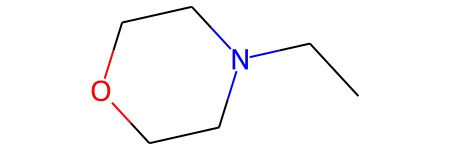

In [13]:
m = Chem.MolFromSmiles('O1CCN(CC)CC1')
m

Since by default RDKit doesn't keep hydrogens they should be added before 3D structure generation to obtain rasonable geometry

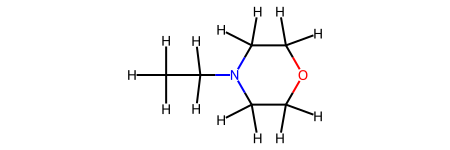

In [14]:
m = Chem.AddHs(m)
m

This command generates 3D structure for a molecule usinf distance matrix approach

In [17]:
AllChem.EmbedMolecule(m)

0

The obtained geometry usually is quite ugly and refinement is neccessary. This can be done by using universal force field (UFF) or Merck molecular force field (MMFF).

In [19]:
AllChem.UFFOptimizeMolecule(m)

0

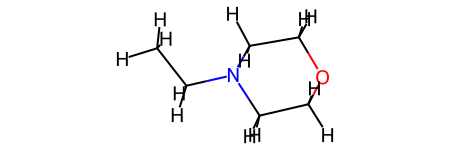

In [20]:
m

In [21]:
AllChem.MMFFOptimizeMolecule(m)

0

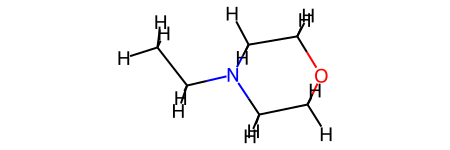

In [22]:
m

### Generation of multiple conformers

There are a lot of input options. The major ones are the number of conformers and RMS threshold, which will help to discard too similar 3D structures and keep diverse conformers.


In [23]:
cids = AllChem.EmbedMultipleConfs(m, numConfs=10, pruneRmsThresh=1)

In [24]:
len(cids)

7

You may see that from 10 required conformers only 7 were generated. If you will decrese the RMS threshold value more conformers will be kept up to specified maximum value (10).

Generated conformers require geometry optimization to produce more reasonable 3D structures.

In [28]:
for cid in cids:
    AllChem.MMFFOptimizeMolecule(m, confId = cid)

For conformers you may corresponding return energy values. Since we optimized geometry with MMFF we will use the same force field for energy calculation.

In [30]:
for cid in cids:
    ff = AllChem.MMFFGetMoleculeForceField(m, AllChem.MMFFGetMoleculeProperties(m), confId = cid)
    print(ff.CalcEnergy())

56.522513327541155
59.97698532877619
64.0923225712593
56.52251332467303
58.313409614070025
58.31340963103609
58.31340955181591
